# Insight Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt

In [3]:
#skLearn and imblearn Dependencies
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids


# Read the CSV and Remove Columns Deemed Low Importance

In [4]:
# Loading data USING CSV that contains cleanded values for MaritalStatus and Gender and dropped OwnCar
file_path = Path("../Resources/TravelCleanedSkiLearnImputer.csv")
df = pd.read_csv(file_path)
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.000000,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.000000,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Single,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.000000,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.000000,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Single,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,37.622265,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Single,1.0,0,5,1,0.0,Executive,18468.0


In [5]:
#Drop columns not needed
features_df = df.copy()
features_df = df.drop(["ProdTaken","CustomerID","Designation","Occupation"], axis=1)
features_df

,Age,TypeofContact,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
0,41.000000,Self Enquiry,3,6.0,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,20993.0
1,49.000000,Company Invited,1,14.0,Male,3,4.0,Deluxe,4.0,Single,2.0,0,3,1,2.0,20130.0
2,37.000000,Self Enquiry,1,8.0,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,17090.0
3,33.000000,Company Invited,1,9.0,Female,2,3.0,Basic,3.0,Single,2.0,1,5,1,1.0,17909.0
4,37.622265,Self Enquiry,1,8.0,Male,2,3.0,Basic,4.0,Single,1.0,0,5,1,0.0,18468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,49.000000,Self Enquiry,3,9.0,Male,3,5.0,Deluxe,4.0,Single,2.0,1,1,1,1.0,26576.0
4884,28.000000,Company Invited,1,31.0,Male,4,5.0,Basic,3.0,Single,3.0,1,3,1,2.0,21212.0
4885,52.000000,Self Enquiry,3,17.0,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,31820.0
4886,19.000000,Self Enquiry,3,16.0,Male,3,4.0,Basic,3.0,Single,3.0,0,5,0,2.0,20289.0


# Split the Data into Training and Testing
## Find Columns with Object Data Types and convert to Floats(numeric)

In [6]:
# Generate our categorical variable list
features_df_cat = features_df.dtypes[features_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
features_df[features_df_cat].nunique()

TypeofContact     2
Gender            2
ProductPitched    5
MaritalStatus     2
dtype: int64

In [7]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(features_df[features_df_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(features_df_cat)
encode_df.head()

,TypeofContact_Company Invited,TypeofContact_Self Enquiry,Gender_Female,Gender_Male,ProductPitched_Basic,ProductPitched_Deluxe,ProductPitched_King,ProductPitched_Standard,ProductPitched_Super Deluxe,MaritalStatus_Married,MaritalStatus_Single
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# Merge one-hot encoded features and drop the originals
features_df = features_df.merge(encode_df,left_index=True, right_index=True)
features_df = features_df.drop(features_df_cat,1)
features_df.head()

,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,...,TypeofContact_Self Enquiry,Gender_Female,Gender_Male,ProductPitched_Basic,ProductPitched_Deluxe,ProductPitched_King,ProductPitched_Standard,ProductPitched_Super Deluxe,MaritalStatus_Married,MaritalStatus_Single
0,41.000000,3,6.0,3,3.0,3.0,1.0,1,2,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,49.000000,1,14.0,3,4.0,4.0,2.0,0,3,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,37.000000,1,8.0,3,4.0,3.0,7.0,1,3,0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33.000000,1,9.0,2,3.0,3.0,2.0,1,5,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,37.622265,1,8.0,2,3.0,4.0,1.0,0,5,1,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# Define the features set.
X = features_df.copy()
X

,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,...,TypeofContact_Self Enquiry,Gender_Female,Gender_Male,ProductPitched_Basic,ProductPitched_Deluxe,ProductPitched_King,ProductPitched_Standard,ProductPitched_Super Deluxe,MaritalStatus_Married,MaritalStatus_Single
0,41.000000,3,6.0,3,3.0,3.0,1.0,1,2,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,49.000000,1,14.0,3,4.0,4.0,2.0,0,3,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,37.000000,1,8.0,3,4.0,3.0,7.0,1,3,0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33.000000,1,9.0,2,3.0,3.0,2.0,1,5,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,37.622265,1,8.0,2,3.0,4.0,1.0,0,5,1,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,49.000000,3,9.0,3,5.0,4.0,2.0,1,1,1,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4884,28.000000,1,31.0,4,5.0,3.0,3.0,1,3,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4885,52.000000,3,17.0,4,4.0,4.0,7.0,0,1,1,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4886,19.000000,3,16.0,3,4.0,3.0,3.0,0,5,0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# Define the target set.
y = df["ProdTaken"]


In [11]:
# Check the balance of our target values
y.value_counts()

0    3968
1     920
Name: ProdTaken, dtype: int64

In [12]:
# Scale and Normalize Data
data_scaled=StandardScaler()

In [13]:
# fit and transfor data
X_scaled=data_scaled.fit_transform(X)
X_scaled[:1]

array([[ 0.37128216,  1.46836869, -1.14387064,  0.13096606, -0.71002119,
        -0.73012744, -1.22740375,  1.56122135, -0.78947679,  0.78239198,
        -1.39356846, -0.50032202, -0.63957142,  0.63957142,  1.21601884,
        -1.21601884, -0.77764228,  1.34987811, -0.22221029, -0.42304572,
        -0.27428265, -0.95831485,  0.95831485]])

In [14]:
#Test and Train of the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=78)

In [15]:
# Check the balance of our target values
y_train.value_counts()

0    2988
1     678
Name: ProdTaken, dtype: int64

In [16]:
#Checking the train vs test allocation
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 2988, 1: 678})
Counter({0: 980, 1: 242})


In [17]:
#Logistic Regression for reference
classifier = LogisticRegression(solver = 'lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [18]:
#fit our model with our data
classifier.fit(X_train, y_train) 

LogisticRegression(random_state=1)

In [19]:
#create Y predictions
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [20]:
#View Data
# Calculate Model Accuracy
pd.DataFrame({"Prediction" :y_pred, "Actual": y_test}).value_counts()

Prediction  Actual
0           0         948
            1         181
1           1          61
            0          32
dtype: int64

In [21]:
#Calcualte model accuracy
accuracy_score(y_test, y_pred)

0.82569558101473

In [22]:
# Create Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[948  32]
 [181  61]]


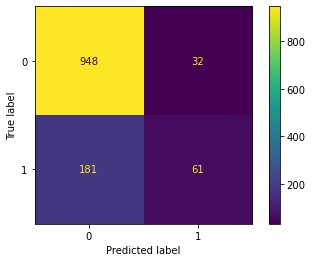

In [23]:
#ConfusionMatrixDisplay to show confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
display.plot()

#Save Image
#plt.savefig("../Images/CRR_TrainSplitFirst_confusion_matrix.png")
plt.show()

In [24]:
#classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       980
           1       0.66      0.25      0.36       242

    accuracy                           0.83      1222
   macro avg       0.75      0.61      0.63      1222
weighted avg       0.80      0.83      0.79      1222



In [25]:
#Imbalanced Classification Report
report = classification_report_imbalanced(y_test, y_pred)
print(report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.97      0.25      0.90      0.49      0.26       980
          1       0.66      0.25      0.97      0.36      0.49      0.23       242

avg / total       0.80      0.83      0.39      0.79      0.49      0.25      1222



# Oversampling

### Naive Random Oversampling

In [26]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
#Checks the Balance
Counter(y_resampled)

Counter({0: 2988, 1: 2988})

In [27]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [28]:
# Fit 
y_pred = model.predict(X_test)

#Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.7120045538876707

In [29]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_df = pd.DataFrame(
    cm, index=["Act ProdTaken 0", "Act ProdTaken 1"], columns=["Pred ProdTaken 0", "Pred ProdTaken 1"])

cm_df

,Pred ProdTaken 0,Pred ProdTaken 1
Act ProdTaken 0,699,281
Act ProdTaken 1,70,172


In [30]:
# Print the imbalanced classification report
print("Naive Random Sampling")
print(classification_report_imbalanced(y_test, y_pred))

Naive Random Sampling
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.71      0.71      0.80      0.71      0.51       980
          1       0.38      0.71      0.71      0.49      0.71      0.51       242

avg / total       0.80      0.71      0.71      0.74      0.71      0.51      1222



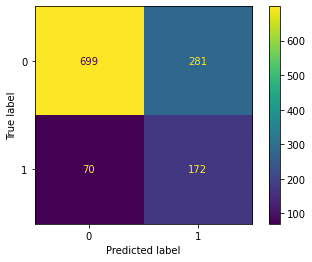

In [31]:
#ConfusionMatrixDisplay to show confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
display.plot()

#Save Image
#plt.savefig("../Images/NaiveRandomOverSampler_confusion_matrix.png")
plt.show()

### SMOTE Oversampling

In [32]:
# Resample the training data with SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

#Result
Counter(y_resampled)

Counter({0: 2988, 1: 2988})

In [33]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [34]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7104486422668241

In [35]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Act ProdTaken 0", "Act ProdTaken 1"], columns=["Pred ProdTaken 0", "Pred ProdTaken 1"])

cm_df

,Pred ProdTaken 0,Pred ProdTaken 1
Act ProdTaken 0,700,280
Act ProdTaken 1,71,171


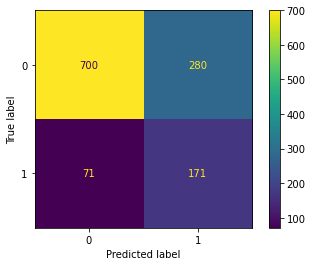

In [36]:
#ConfusionMatrixDisplay to show confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
display.plot()

#Save Image
#plt.savefig("../Images/SMOTEOverSampler_confusion_matrix.png")
plt.show()

In [37]:
# Print the imbalanced classification report
# Print the imbalanced classification report
print("SMOTE Oversampling")
print(classification_report_imbalanced(y_test, y_pred))

SMOTE Oversampling
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.71      0.71      0.80      0.71      0.51       980
          1       0.38      0.71      0.71      0.49      0.71      0.50       242

avg / total       0.80      0.71      0.71      0.74      0.71      0.50      1222



# Undersampling

In [38]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 678, 1: 678})

In [39]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [40]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7058568055321301

In [41]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_df = pd.DataFrame(
    cm, index=["Act ProdTaken 0", "Act ProdTaken 1"], columns=["Pred ProdTaken 0", "Pred ProdTaken 1"])

cm_df

,Pred ProdTaken 0,Pred ProdTaken 1
Act ProdTaken 0,691,289
Act ProdTaken 1,71,171


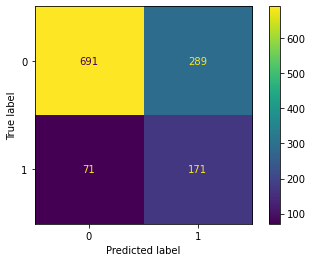

In [42]:
#ConfusionMatrixDisplay to show confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
display.plot()

#Save Image
#plt.savefig("../Images/ClusterCentroidUnderSampler_confusion_matrix.png")
plt.show()

In [43]:
# Print the imbalanced classification report
print("Cluster Centroid Undersampling")
print(classification_report_imbalanced(y_test, y_pred))

Cluster Centroid Undersampling
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.71      0.71      0.79      0.71      0.50       980
          1       0.37      0.71      0.71      0.49      0.71      0.50       242

avg / total       0.80      0.71      0.71      0.73      0.71      0.50      1222



# Combination (Over and Under) Sampling

SMOTEENN

In [44]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
#X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 2237, 1: 2860})

In [45]:
# Train the Logistic Regression model using the resampled data

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [46]:
# Calculated the balanced accuracy score

y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7032003710575139

In [47]:
# Display the confusion matrix

#y_pred = model.predict(X_test)
#confusion_matrix(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Act ProdTaken 0", "Act ProdTaken 1"], columns=["Pred ProdTaken 0", "Pred ProdTaken 1"])

cm_df

,Pred ProdTaken 0,Pred ProdTaken 1
Act ProdTaken 0,621,359
Act ProdTaken 1,55,187


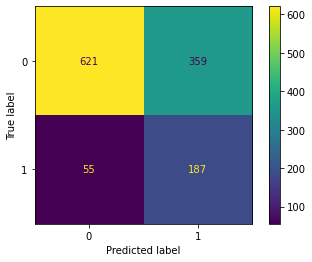

In [48]:
#ConfusionMatrixDisplay to show confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
display.plot()

#Save Image
#plt.savefig("../Images/SMOTEENOverUnderSampler_confusion_matrix.png")
plt.show()

In [49]:
# Print the imbalanced classification report
print("SMOTEEN Over and Undersampling")
print(classification_report_imbalanced(y_test, y_pred))

SMOTEEN Over and Undersampling
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.63      0.77      0.75      0.70      0.48       980
          1       0.34      0.77      0.63      0.47      0.70      0.50       242

avg / total       0.80      0.66      0.75      0.70      0.70      0.49      1222

